In [1]:
%pylab inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from pandas.core import datetools

Populating the interactive namespace from numpy and matplotlib


/Users/anastasiarogachevskaya/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


***Визуализация ряда***

In [2]:
data = pd.read_csv('monthly-beer-production-in-austr.csv', index_col=['Month'], parse_dates=['Month'])

In [3]:
data = data.rename(columns = {'Monthly beer production in Australia: megalitres. Includes ale and stout. Does not include beverages with alcohol percentage less than 1.15. Jan 1956 ? Aug 1995':'Beer Production'})

In [4]:
data = data.dropna()

In [5]:
data.head()

,Beer Production
Month,
1956-01,93.2
1956-02,96.0
1956-03,95.2
1956-04,77.1
1956-05,70.9


In [6]:
data.tail()

,Beer Production
Month,
1995-04,127.0
1995-05,151.0
1995-06,130.0
1995-07,119.0
1995-08,153.0


In [7]:
data.shape

(476, 1)

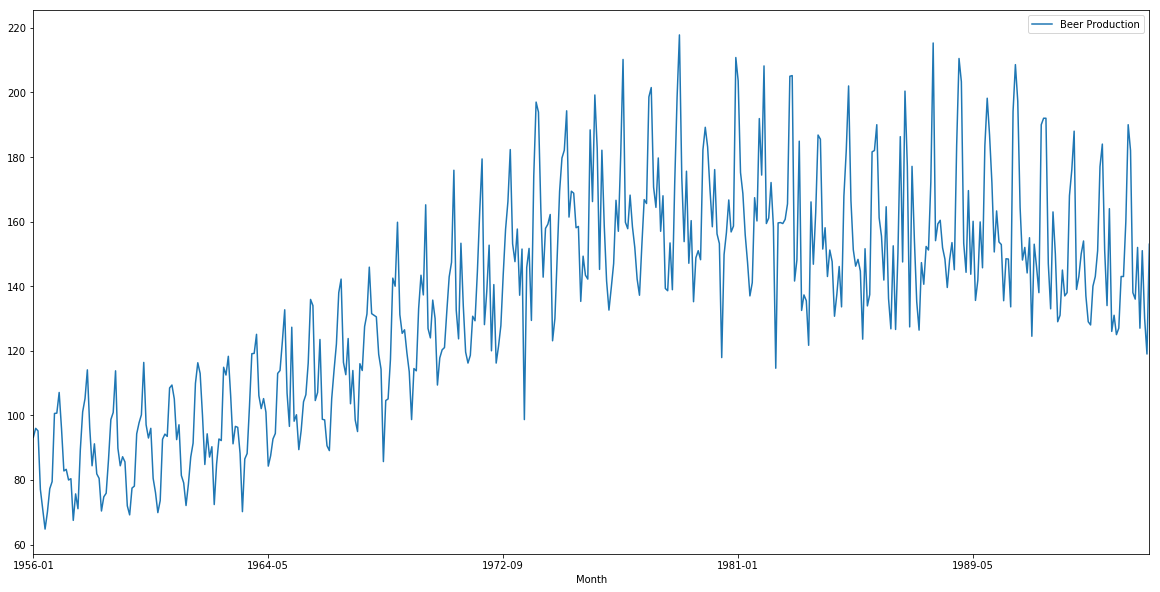

In [8]:
data.plot(figsize=(20,10))

***Стационаризация ряда***

*Проверим ряд на стационарность:*

In [9]:
x = sm.tsa.adfuller(data['Beer Production'])

In [10]:
print('p-value :' + str(x[1]))

p-value :0.177620998291


*Ряд не стационарен. Критерий Дики-Фуллера не отверг нулевую гипотезу о наличии единичного корня (о нестационарности ряда).*

*Выполним STL-декомпозицию:*

In [11]:
data.reset_index(inplace=True)
data['Month'] = pd.to_datetime(data['Month'])
data = data.set_index('Month')

In [12]:
data.head()

,Beer Production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


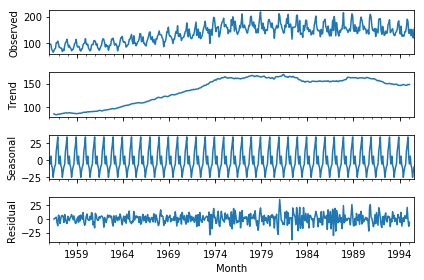

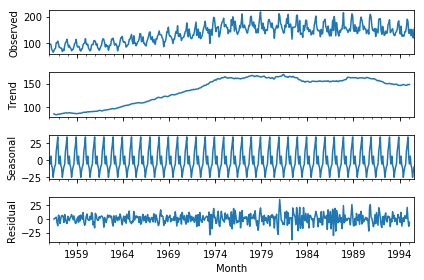

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(data)
res.plot()

*Выполним преобразование Бокса-Кокса, чтобы стабилизировать дисперсию:*

In [14]:
from scipy.stats import boxcox
data_bxcx = boxcox(data['Beer Production'])
print('p-value :' + str(sm.tsa.adfuller(data_bxcx[0])[1]))

p-value :0.170889290909


In [15]:
data['Beer With Boxcox'] = data_bxcx[0]

In [16]:
data.head()

,Beer Production,Beer With Boxcox
Month,,
1956-01-01,93.2,78.347832
1956-02-01,96.0,80.622665
1956-03-01,95.2,79.973026
1956-04-01,77.1,65.203629
1956-05-01,70.9,60.109640


*Сезонное дифференцирование:*

In [17]:
data['Beer Production Diff'] = data['Beer With Boxcox'] - data['Beer With Boxcox'].shift(12)
#из графика видно, что период сезонности = 12

In [18]:
data = data.dropna()

p-value :0.04676665255


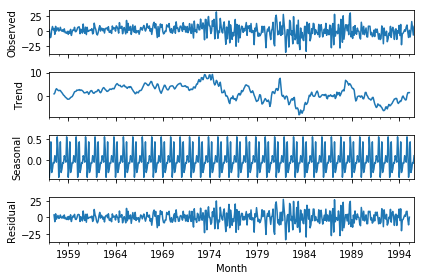

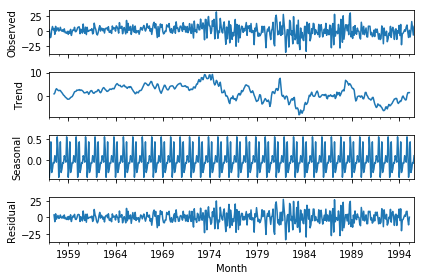

In [19]:
season = sm.tsa.seasonal_decompose(data['Beer Production Diff'])
print('p-value :' + str(sm.tsa.adfuller(data['Beer Production Diff'])[1]))
season.plot()

*Обычное дифференцирование:*

In [20]:
data['Beer Production Diff Simple'] = data['Beer Production Diff'] - data['Beer Production Diff'].shift(1)

In [21]:
data = data.dropna()

p-value :5.49839600997e-14


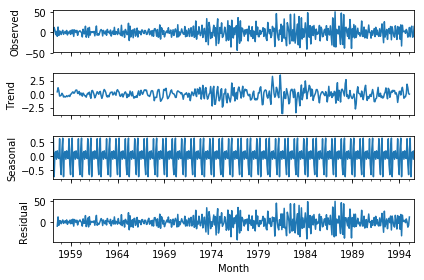

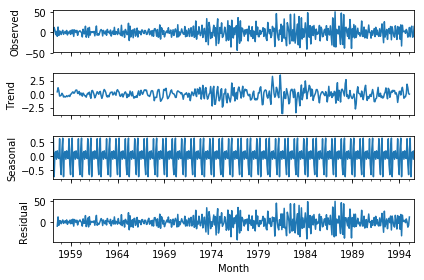

In [22]:
season = sm.tsa.seasonal_decompose(data['Beer Production Diff Simple'])
print('p-value :' + str(sm.tsa.adfuller(data['Beer Production Diff Simple'])[1]))
season.plot()

 *Ряд стационарен.*

***Построение коррелограмм ACF и PACF и поиск параметров (p, d, q), (P, D, Q) для сезонной модели ARIMA (SARIMA)***

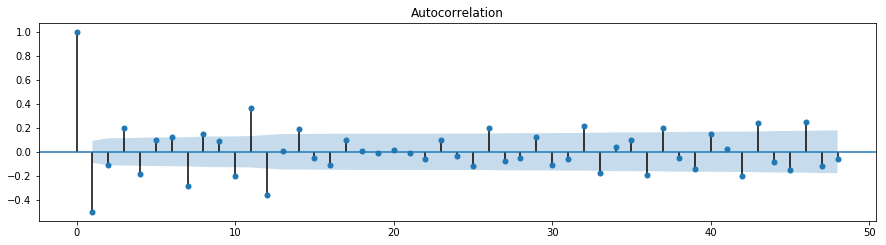

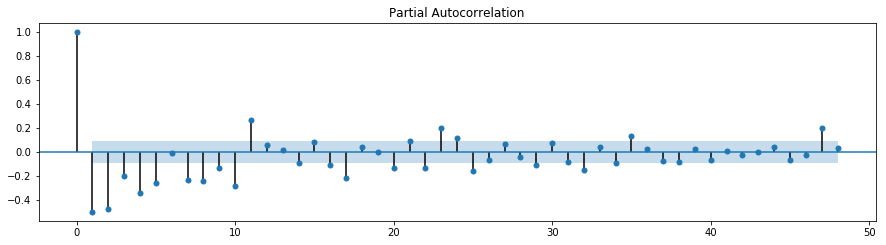

In [23]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['Beer Production Diff Simple'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['Beer Production Diff Simple'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [24]:
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)

In [25]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

***Выбор параметров и построение модели***

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
result = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = SARIMAX(endog = data['Beer With Boxcox'], order = (param[0], d, param[1]), seasonal_order = (param[2], D, param[3], 12))
        model = model.fit()
        # обучаем модель tsa.statespace.SARIMAX
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    result.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 2, 0, 0)
wrong parameters: (0, 2, 0, 1)
wrong parameters: (0, 2, 1, 0)
wrong parameters: (0, 2, 1, 1)
wrong parameters: (0, 4, 0, 0)
wrong parameters: (0, 4, 0, 1)
wrong parameters: (0, 4, 1, 0)
wrong parameters: (0, 4, 1, 1)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (1, 2, 1, 1)
wrong parameters: (1, 4, 0, 0)
wrong parameters: (1, 4, 0, 1)
wrong parameters: (1, 4, 1, 0)
wrong parameters: (1, 4, 1, 1)
wrong parameters: (2, 4, 0, 0)
wrong parameters: (2, 4, 0, 1)
wrong parameters: (2, 4, 1, 0)
wrong parameters: (2, 4, 1, 1)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (4, 3, 0, 0)
wrong parameters: (4, 3, 0, 1)
wrong parameters: (4, 3, 1, 0)
wrong parameters: (4, 3, 1, 1)


In [27]:
result_table = pd.DataFrame(result)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
36  (2, 3, 0, 1)  3092.538615
38  (2, 3, 1, 1)  3117.718663
62  (4, 1, 1, 1)  3135.225501
60  (4, 1, 0, 1)  3136.495894
66  (4, 2, 1, 1)  3136.876270


In [28]:
best_model = sm.tsa.statespace.SARIMAX(data['Beer With Boxcox'], order=(2, d, 3), 
                                        seasonal_order=(0, D, 1, 12)).fit(disp=-1)
print(best_model.summary())

/Users/anastasiarogachevskaya/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                   Beer With Boxcox   No. Observations:                  463
Model:             SARIMAX(2, 1, 3)x(0, 1, 1, 12)   Log Likelihood               -1539.269
Date:                            Thu, 14 Dec 2017   AIC                           3092.539
Time:                                    17:44:19   BIC                           3121.503
Sample:                                02-01-1957   HQIC                          3103.941
                                     - 08-01-1995                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1548      0.003   -443.338      0.000      -1.160      -1.150
ar.L2         -0.9987      0.003   

*Проверим, что остатки являются "белым шумом", не смещены и стационарны:*

Критерий Стьюдента: p=0.449541
Критерий Дики-Фуллера: p=0.000093


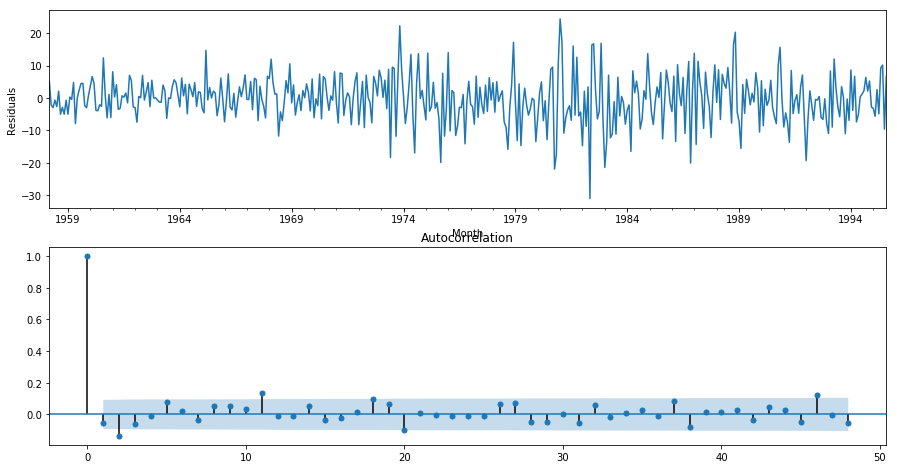

In [29]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

***Построение прогноза:***

*Как ведет себя модель на данных:*

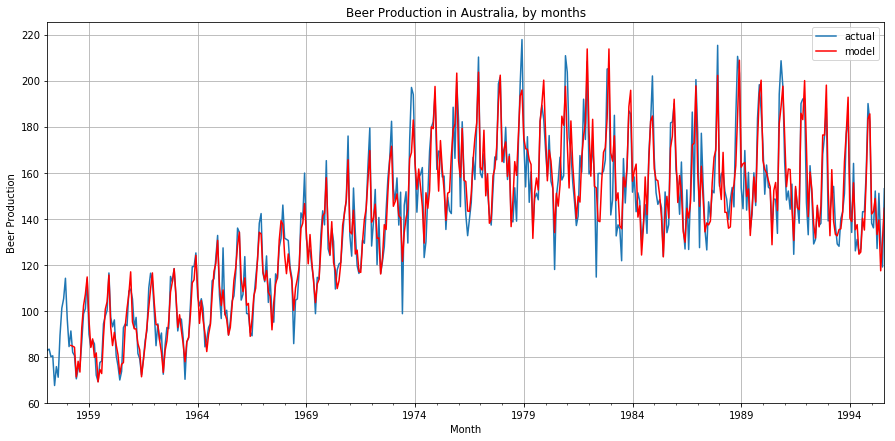

In [30]:
def invboxcox(y, lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
    

data['ARIMA'] = invboxcox(best_model.fittedvalues, lmbda = data_bxcx[1])
plt.figure(figsize(15,7))
data['Beer Production'].plot(label = 'actual')
data['ARIMA'][13:].plot(color='r', label = 'model')
plt.legend()
plt.title('Beer Production in Australia, by months')
plt.ylabel('Beer Production')
plt.grid(True)
pylab.show()

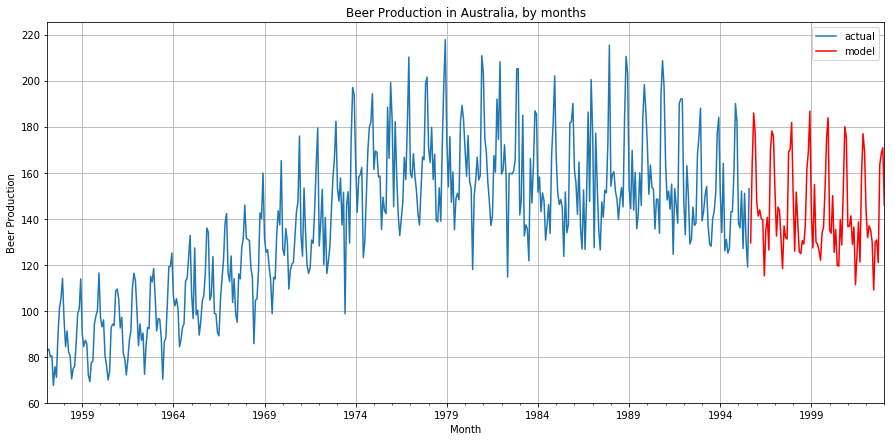

In [31]:
data2 = data[['Beer Production']]
date_list = [datetime.datetime.strptime("1995-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,90)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+90), lmbda = data_bxcx[1])

plt.figure(figsize(15,7))
data['Beer Production'].plot(label="actual")
data2['forecast'].plot(color='r', label="model")
plt.title('Beer Production in Australia, by months')
plt.legend()
plt.ylabel('Beer Production')
plt.grid(True)
pylab.show()

***Комментарий: модель неплохо обучилась, предсказание хорошее, на мой взгляд.***